# Demonstration for DEFRA

__Description & purpose__: This Notebook is designed to showcase the initial functionality of the Earth Observation Data Hub. It provides a snapshot of the Hub, the `pyeodh` API client and the various datasets as of September 2024. The Notebook "user" would like to understand more about the satellite data available for their test areas. This user is also interested in obtaining a series of smaller images and ultimately creating a data cube. The Notebook series (of 3) is designed in such a way that it can be run on the EODH AppHub (Notebook Service) or from a local environment.  

__Author(s)__: Alastair Graham, Dusan Figala, Phil Kershaw

__Date created__: 2024-09-05

__Date last modified__: 2024-09-18

__Licence__: This notebook is licensed under [Creative Commons Attribution-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-sa/4.0/).  The code is released using the [BSD-2-Clause](https://www.tldrlegal.com/license/bsd-2-clause-license-freebsd) license.


<span style="font-size:0.75em;">
Copyright (c) , All rights reserved.</span>

<span style="font-size:0.75em;">
Redistribution and use in source and binary forms, with or without modification, are permitted provided that the following conditions are met:</span>

<span style="font-size:0.75em;">
Redistributions of source code must retain the above copyright notice, this list of conditions and the following disclaimer. Redistributions in binary form must reproduce the above copyright notice, this list of conditions and the following disclaimer in the documentation and/or other materials provided with the distribution. THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.</span>

__Links__:
* Oxidian: https://www.oxidian.com/
* CEDA: https://www.ceda.ac.uk/ 
* EO Data Hub: https://eodatahub.org.uk/

# What is the EODH?
The Earth Observation Data Hub is:

"A UK Pathfinder project delivering access to Earth Observation (EO) data for effective decisionmaking across government, business and academia. The Earth Observation DataHub (EODH) brings together an expert project delivery team and industrial partners in an ambitious project... Users of the Hub will be able to explore areas of interest in the UK and across the globe... It will also enable selected users to support their own analyses, services and tools using the Hub’s workflow and compute environments."

More details can be found online at https://eodatahub.org.uk/

Components of the Hub include:
* A Resource Catalogue - a STAC compliant catalogue of open and commercial satellite imagery, climate data, model results, workflows and more
* A Workflow Runner - a dedicated piece of cloud infrastructure to horizontally scale workflow requirements
* A Web Presence - an intuitive user interface to allow account management, data discovery and mapping
* An App Hub - a science portal providing access to a Jupyter lab environment 

### Presentation set up

The following cell only needs to be run on the EODH AppHub.  If you have a local Python environment running, please install the required packages as you would normally.

In [ ]:
# If needed you can install a package in the current AppHub Jupyter environment using pip
# For instance, we will need at least the following libraries
import sys
!{sys.executable} -m pip install --upgrade pyeodh pandas matplotlib numpy pillow folium

# EODH: it's massive compute
The EODH compute architecture is built around a new OGC standard called EO Application Packages (EOAP). These are complex constructions of code and data, and at their core is the concept of a Common Workflow Language (CWL) workflow. To run CWL workflows you need a CWL runner, and the EODH Workflow Runner provides that. The EOAPs require a workflow description in CWL, a Docker container, bespoke scripts and links to the data. In the case of EODH, the data inputs and outputs are to be provided as STAC catalogues. Oxidian, as part of our work developing integrations for the Hub, have created a generator tool `eoap-gen` that abstracts away much of the complexity (check out the training materials repository and website for more details).   

Oxidian have also developed a QGIS plugin to allow desktop users to discover, parameterise and execute workflows on the Hub.

In [ ]:
# Imports
import pyeodh

import os
from requests import HTTPError

In [ ]:
# First the user needs to connect to the Workflow Runner
# Currently this is done by obtaining a user account and API key from the core development team. Here, those details have been saved in secrets.txt
# secrets.txt should contain the two lines below where USERNAME and API_KEY are specific to the user:
# USER="USERNAME"
# PSWD="API_KEY" 

with open('secrets.txt', 'r') as file:
    lines = file.readlines()
    username = lines[0].strip().split('=')[1].strip('"')
    token = lines[1].strip().split('=')[1].strip('"')

clientwfr = pyeodh.Client(username=username, token=token, s3_token=token)
wfr = clientwfr.get_ades()

Our user wants to know what workflows they have access to in their workspace on the Hub.

In [ ]:
# List the workflows available in the user workspace
for p in wfr.get_processes():
    print(p.id)

As development continues the number of demonstration workflows available to users will increase. With uptake of the generator tool users will also be able to create their own bespoke workflows. In time, the Hub will contain organisational accounts and the ability to share workflow files.

Our user wants to deploy a workflow that they have found online. They can do so for compliant CWL files by submitting the URl. 

In [ ]:
# Deploy a workflow using a URL to a .cwl file hosted online
convert_url_proc = wfr.deploy_process(
    cwl_url="https://raw.githubusercontent.com/EOEPCA/deployment-guide/main/deploy/samples/requests/processing/convert-url-app.cwl"
)
print(convert_url_proc.id, convert_url_proc.description, ": Deployed")
print('')
# List the available workflows
for p in wfr.get_processes():
    print(p.id)

In [ ]:
# If a user wants to tidy their workspace or no longer wants access to a workflow they can remove it
try:
    wfr.get_process("convert-url").delete()
    print("Process removed")
except HTTPError:
    print("Process not found")

The user is interested in the ARD files, but they are too large for the task that they want to undertake. The workflow file linked to [here](https://github.com/figi44/eoap/blob/main/resize-collection.cwl) takes a series of data from the Sentinel 2 ARD collection and resizes the imagery using gdal_translate. The CWL file needs to be submitted to the Workflow Runner and parameterised, before it can then be run.  

In [ ]:
# Deploy the workflow
# Remove an existing nstance of the workflow
try:
    wfr.get_process("convert-img").delete()
    print("Process removed")
except HTTPError:
    print("Process not found")

# Deploy from a URL to a .cwl file hosted online
#img_proc = wfr.deploy_process(cwl_yaml=cwl_yaml)
img_proc = wfr.deploy_process(cwl_url='https://raw.githubusercontent.com/ajgwords/eodh-tests/main/resize-col.cwl')

print(img_proc.id, img_proc.description, ": Deployed")
print('')
# List the available workflows
for p in wfr.get_processes():
    print(p.id)

As part of the presentation we looked at the plugin offline. Screenshots are provided here for those who do not have the plugin installed.

Once the CWL file has been submitted then it is possible for users with suitable permissions to also view the list of available workflows through the QGIS plugin.

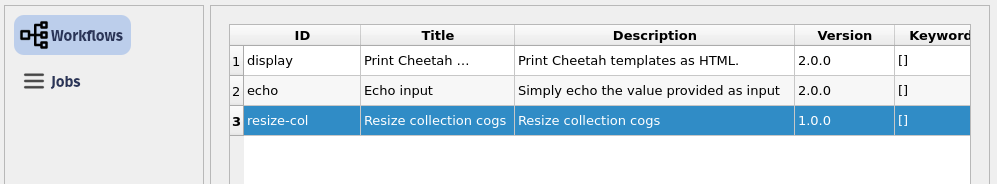

The user can choose and parameterise a workflow using the QGIS plugin as shown in this screenshot. A series of defaults are provided with all workflow files so a user can run the workflow straight away using those. To do so in code, the user provides an empty dictionary. 

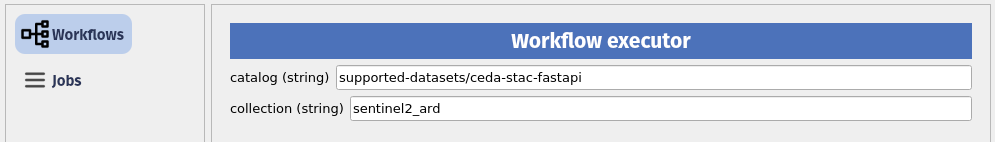

In [ ]:
# Run the workflow using the defaults
pyeodh.set_log_level(10) # set the logging to be verbose

resize_job = img_proc.execute(
    {
    }
)

print(resize_job.id, resize_job.status, resize_job.message)


In [ ]:
resize_job.refresh()
print(resize_job.id, resize_job.status, resize_job.message)

The outputs above show the status of the running job: `"status": "running"`. The job status can also be monitored using the QGIS plugin.

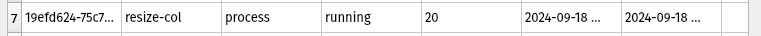

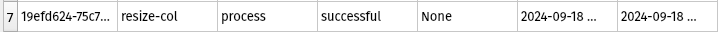

The outputs are accessible and loadable from the QGIS plugin.

Original image: 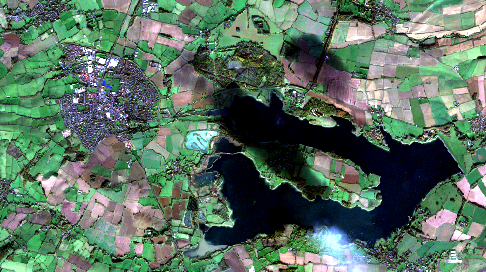  

Resampled image: 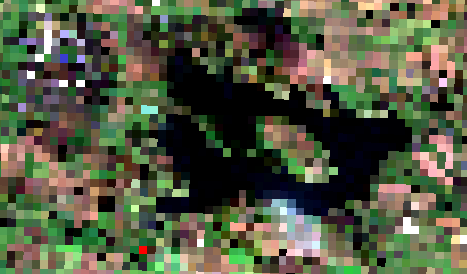

The workflow outputs are available in a users's workspace and are attached to the job id presented through the QGIS plugin. A user can open any output from within the plugin to be displayed in the QGIS map window. 